# Neural Network Training

In [68]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

class Layer :
    def __init__(self,weight,bias) :
        self.weight = weight
        self.bias =  bias
        
    def activationSigmoid(self,input) : #Sigmoid
        sigmoid = torch.sigmoid(input)
        return sigmoid
    
    def activationRelu(self,input) : #Sigmoid
        m = nn.ReLU()
        return m(input)
    
    def activationSM(self,input) : #Sigmoid
        A = torch.exp(input) / sum(torch.exp(input))
        return A

    def forward1(self, input) :
        output=(torch.matmul(input,self.weight))+self.bias
        return output,self.activationRelu(output)
    
    
    def forward2(self, input) :
        output=(torch.matmul(input,self.weight))+self.bias
        return output,self.activationSM(output)
        
    
       
class Network:
    def __init__(self,w1,b1,w2,b2, batch_size = 10):
        self.batch_size = batch_size
        # network
        self.layer1 = Layer(w1,b1)
        self.layer2 = Layer(w2,b2)
#         self.layer3 = Layer(w3,b3)

    def forward1(self, x):
        pred,a = self.layer1.forward1(x)
        return pred,a
    
    def forward2(self, x):
        pred,y = self.layer2.forward2(x)
        return pred,y

    
    def single_processing(self, input, target) :
            pred1,error1 = self.forward1(input)
            pred2,error2 = self.forward2(error1)
            return pred1,error1,pred2,error2
            
    
    def evaluate(self, pred, target) : #L1
        loss = nn.L1Loss()
        output = loss(pred,target)
        return output        
                
    #Create batch, then process each batch
    def batch_processing(self, input, target) :
        for i in range(0,len(input)-1,2):
            new_len=[input[i].tolist(),input[i+1].tolist()]
            new_ten=torch.Tensor(new_len)
            new_tar=[target[i].tolist(),target[i+1].tolist()]
            new_tar2=torch.Tensor(new_tar)
            self.single_processing(new_ten,new_tar2)



# Load Data

In [2]:
trainset= MNIST('dataset_mnist',True, download= True)
trainset= MNIST('dataset_mnist',False, download= True)

In [3]:
trainset.data.shape

torch.Size([10000, 28, 28])

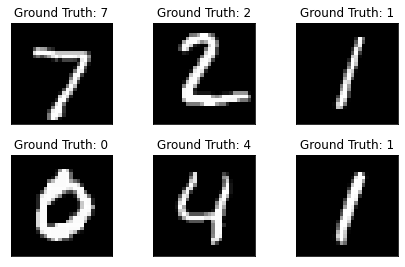

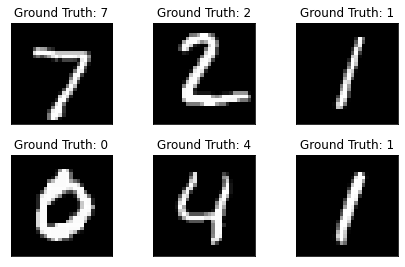

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(trainset[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(trainset.targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [5]:

print(trainset.targets)

tensor([7, 2, 1,  ..., 4, 5, 6])


# Modeling Data

In [87]:
x_train=trainset.data
y_train=trainset.targets
x_train=x_train.reshape(-1,28*28)
x_train=x_train.float()
x_train=x_train/255
print(x_train)
print(y_train)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([7, 2, 1,  ..., 4, 5, 6])


# Call Neural Network Training Class

In [112]:

seed=52
learning_rate=0.01

m, n = x_train.shape
X_train = x_train[1:n]
_,m_train = X_train.shape
print (m,n)
epoch=100
acc=0
target=torch.zeros(10)
target=y_train[1]/10
print (target)

                
def one_hot(Y):
    one_hot_Y = np.zeros((list(y_train.shape)[0], 10))
    one_hot_Y[np.arange(list(y_train.shape)[0]), Y] = 1
    one_hot_Y = one_hot_Y
    return one_hot_Y.astype(float)
   
def ReLU_deriv(Z):
    return (Z > 0) * 1
    
    
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
        one_hot_Y = one_hot(Y)      
        dZ2 = A2 - one_hot_Y
        dZ2=dZ2.float()
        dW2 = 1 / m * torch.matmul(dZ2.t(),A1)
        db2 = 1 / m * torch.sum(dZ2)
        dZ1 = torch.matmul(dZ2,W2) * ReLU_deriv(Z1)
        dZ1=dZ1.float()
        dW1 = 1 / m * torch.matmul(X.t(),dZ1)
        db1 = 1 / m * torch.sum(dZ1)
        return dW1, db1, dW2, db2

def get_predictions(A2):
    return torch.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return torch.sum(predictions == Y) / 1000

def forward_prop(w1, b1, w2, b2 , X):
    model = Network(w1,b1,w2,b2)
    pred1,error1,pred2,error2=model.single_processing(x_train,y_train)
    return pred1, error1, pred2, error2
        
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2   
    return W1, b1, W2, b2

def init_params():
    w1 = torch.randn((784,10))
    b1 =  torch.randn((10))
    #layer2
    w2 = torch.randn((10,10))
    b2 =  torch.randn((10))
    return w1,b1,w2,b2
    
def gradient_descent(X, Y, alpha, iterations):
    w1, b1, w2, b2 = init_params()
    for i in range(iterations):
        print("w1: ",w1)
        Z1, A1, Z2, A2 = forward_prop(w1,b1,w2, b2, X)        
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, w1, w2, X, Y)
        w1,b1,w2, b2 = update_params(w1,b1,w2, b2, dW1, db1, dW2, db2,alpha)
        print("w1: ",w1)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2.t())
            print("Predict: ", predictions, "Y:", Y)
            print(get_accuracy(predictions, Y))
    return w1,b1,w2, b2


W1, b1, W2, b2 = gradient_descent(x_train, y_train, 0.01, 500)

        


10000 784
tensor(0.2000)
w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.6063,  1.7560,  1.6831],
        [-1.1806, -0.3556,  0.6461,  ...,  0.6227,  1.6619, -1.1830],
        ...,
        [-0.6614, -0.4115,  0.6024,  ...,  1.6988, -1.2479,  2.3443],
        [-1.3976,  0.5511,  0.7421,  ..., -0.7928, -0.3213,  1.0497],
        [-1.4677,  1.6829,  0.4144,  ..., -0.4200, -1.2781,  1.6146]])
w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.6063,  1.7560,  1.6831],
        [-1.1806, -0.3556,  0.6461,  ...,  0.6227,  1.6619, -1.1830],
        ...,
        [-0.6614, -0.4115,  0.6024,  ...,  1.6988, -1.2479,  2.3443],
        [-1.3976,  0.5511,  0.7421,  ..., -0.7928, -0.3213,  1.0497],
        [-1.4677,  1.6829,  0.4144,  ..., -0.4200, -1.2781,  1.6146]])
Iteration:  0
Predict:  tensor([3, 5, 5,  ..., 2, 3, 2]) Y: tensor([7, 2, 1,  ..., 4, 5, 6])
tens

w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.6063,  1.7560,  1.6831],
        [-1.1806, -0.3556,  0.6461,  ...,  0.6227,  1.6619, -1.1830],
        ...,
        [-0.6614, -0.4115,  0.6024,  ...,  1.6988, -1.2479,  2.3443],
        [-1.3976,  0.5511,  0.7421,  ..., -0.7928, -0.3213,  1.0497],
        [-1.4677,  1.6829,  0.4144,  ..., -0.4200, -1.2781,  1.6146]])
w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.6063,  1.7560,  1.6831],
        [-1.1806, -0.3556,  0.6461,  ...,  0.6227,  1.6619, -1.1830],
        ...,
        [-0.6614, -0.4115,  0.6024,  ...,  1.6988, -1.2479,  2.3443],
        [-1.3976,  0.5511,  0.7421,  ..., -0.7928, -0.3213,  1.0497],
        [-1.4677,  1.6829,  0.4144,  ..., -0.4200, -1.2781,  1.6146]])
w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.60

w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.6063,  1.7560,  1.6831],
        [-1.1806, -0.3556,  0.6461,  ...,  0.6227,  1.6619, -1.1830],
        ...,
        [-0.6614, -0.4115,  0.6024,  ...,  1.6988, -1.2479,  2.3443],
        [-1.3976,  0.5511,  0.7421,  ..., -0.7928, -0.3213,  1.0497],
        [-1.4677,  1.6829,  0.4144,  ..., -0.4200, -1.2781,  1.6146]])
w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.6063,  1.7560,  1.6831],
        [-1.1806, -0.3556,  0.6461,  ...,  0.6227,  1.6619, -1.1830],
        ...,
        [-0.6614, -0.4115,  0.6024,  ...,  1.6988, -1.2479,  2.3443],
        [-1.3976,  0.5511,  0.7421,  ..., -0.7928, -0.3213,  1.0497],
        [-1.4677,  1.6829,  0.4144,  ..., -0.4200, -1.2781,  1.6146]])
w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.60

w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.6063,  1.7560,  1.6831],
        [-1.1806, -0.3556,  0.6461,  ...,  0.6227,  1.6619, -1.1830],
        ...,
        [-0.6614, -0.4115,  0.6024,  ...,  1.6988, -1.2479,  2.3443],
        [-1.3976,  0.5511,  0.7421,  ..., -0.7928, -0.3213,  1.0497],
        [-1.4677,  1.6829,  0.4144,  ..., -0.4200, -1.2781,  1.6146]])
w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.6063,  1.7560,  1.6831],
        [-1.1806, -0.3556,  0.6461,  ...,  0.6227,  1.6619, -1.1830],
        ...,
        [-0.6614, -0.4115,  0.6024,  ...,  1.6988, -1.2479,  2.3443],
        [-1.3976,  0.5511,  0.7421,  ..., -0.7928, -0.3213,  1.0497],
        [-1.4677,  1.6829,  0.4144,  ..., -0.4200, -1.2781,  1.6146]])
w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.60

w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.6063,  1.7560,  1.6831],
        [-1.1806, -0.3556,  0.6461,  ...,  0.6227,  1.6619, -1.1830],
        ...,
        [-0.6614, -0.4115,  0.6024,  ...,  1.6988, -1.2479,  2.3443],
        [-1.3976,  0.5511,  0.7421,  ..., -0.7928, -0.3213,  1.0497],
        [-1.4677,  1.6829,  0.4144,  ..., -0.4200, -1.2781,  1.6146]])
w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.6063,  1.7560,  1.6831],
        [-1.1806, -0.3556,  0.6461,  ...,  0.6227,  1.6619, -1.1830],
        ...,
        [-0.6614, -0.4115,  0.6024,  ...,  1.6988, -1.2479,  2.3443],
        [-1.3976,  0.5511,  0.7421,  ..., -0.7928, -0.3213,  1.0497],
        [-1.4677,  1.6829,  0.4144,  ..., -0.4200, -1.2781,  1.6146]])
w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.60

w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.6063,  1.7560,  1.6831],
        [-1.1806, -0.3556,  0.6461,  ...,  0.6227,  1.6619, -1.1830],
        ...,
        [-0.6614, -0.4115,  0.6024,  ...,  1.6988, -1.2479,  2.3443],
        [-1.3976,  0.5511,  0.7421,  ..., -0.7928, -0.3213,  1.0497],
        [-1.4677,  1.6829,  0.4144,  ..., -0.4200, -1.2781,  1.6146]])
w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.6063,  1.7560,  1.6831],
        [-1.1806, -0.3556,  0.6461,  ...,  0.6227,  1.6619, -1.1830],
        ...,
        [-0.6614, -0.4115,  0.6024,  ...,  1.6988, -1.2479,  2.3443],
        [-1.3976,  0.5511,  0.7421,  ..., -0.7928, -0.3213,  1.0497],
        [-1.4677,  1.6829,  0.4144,  ..., -0.4200, -1.2781,  1.6146]])
w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.60

w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.6063,  1.7560,  1.6831],
        [-1.1806, -0.3556,  0.6461,  ...,  0.6227,  1.6619, -1.1830],
        ...,
        [-0.6614, -0.4115,  0.6024,  ...,  1.6988, -1.2479,  2.3443],
        [-1.3976,  0.5511,  0.7421,  ..., -0.7928, -0.3213,  1.0497],
        [-1.4677,  1.6829,  0.4144,  ..., -0.4200, -1.2781,  1.6146]])
w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.6063,  1.7560,  1.6831],
        [-1.1806, -0.3556,  0.6461,  ...,  0.6227,  1.6619, -1.1830],
        ...,
        [-0.6614, -0.4115,  0.6024,  ...,  1.6988, -1.2479,  2.3443],
        [-1.3976,  0.5511,  0.7421,  ..., -0.7928, -0.3213,  1.0497],
        [-1.4677,  1.6829,  0.4144,  ..., -0.4200, -1.2781,  1.6146]])
w1:  tensor([[-0.9081,  0.1780,  1.4294,  ..., -0.6474, -1.2145,  0.1029],
        [ 0.0675,  1.6127, -0.0321,  ..., -0.60

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
Iteration:  340
Predict:  tensor([0, 0, 0,  ..., 0, 0, 0]) Y: tensor([7, 2, 1,  ..., 4, 5, 6])
tensor(0.9800)
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
Iteration:  400
Predict:  tensor([0, 0, 0,  ..., 0, 0, 0]) Y: tensor([7, 2, 1,  ..., 4, 5, 6])
tensor(0.9800)
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
Iteration:  430
Predict:  tensor([0, 0, 0,  ..., 0, 0, 0]) Y: tensor([7, 2, 1,  ..., 4, 5, 6])
tensor(0.9800)
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
Iteration:  460
Predict:  tensor([0, 0, 0,  ..., 0, 0, 0]) Y: tensor([7, 2, 1,  ..., 4, 5, 6])
tensor(0.9800)
w1:  

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan,

w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
w1:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
Iteration:  490
Predict:  tensor([0, 0, 0,  ..., 0, 0, 0]) Y: tensor([7, 2, 1,  ..., 4, 5, 6])
tensor(0.9800)
w1:  